In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.colors as mcolors
from loadmodules import *
import scipy as sp

from numba import njit, config, get_num_threads
config.THREADING_LAYER = 'omp'
print("Numba threads:", get_num_threads())

%matplotlib inline

Numba threads: 16


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
# path = './Auriga_SC/K12_fiducial/'
path = './'
simulation_list = [directory for directory in os.listdir(path) if 'lvl4_d8ad_dr' in directory]
print(simulation_list)

['Au6_lvl4_d8ad_drh0', 'Au18_lvl4_d8ad_drh0']


# ICMF sampling test

In [3]:
sim_id = 1
snap_id = 127
print('Loading simulation ', simulation_list[sim_id], ' snapshot ', snap_id)
sf = load_subfind(snap_id, dir=path+simulation_list[sim_id]+'/output/', hdf5=True, loadonly=['fpos', 'frc2', 'svel', 'flty', 'fnsh', 'slty', 'spos', 'smty', 'ffsh'] )
s = gadget_readsnap(snap_id, snappath=path+simulation_list[sim_id]+'/output/', subfind=sf, hdf5=True, applytransformationfacs=True, loadonlyhalo=0)
s.calc_sf_indizes( sf )
galrad = 0.75 * sf.data['frc2'][0]   
s.select_halo( sf, use_principal_axis=True, use_cold_gas_spin=False, do_rotation=True )

Loading simulation  Au18_lvl4_d8ad_drh0  snapshot  127


/users/aripcont/pylib/gadget_snap.py:732: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


galrad= 0.022342459857463838
Found 2229646 stars.
Rotated pos.
Rotated bfld.
Rotated vel.


array([[-0.6333366 , -0.29175326,  0.71677388],
       [ 0.53098319,  0.50996828,  0.67674899],
       [-0.56297567,  0.80920478, -0.1680655 ]])

In [4]:
solar_mass_g = 1.989e33
Gcosmo = 43.
k = 1.3807e-16 # boltzmann constant in erg/K (g*cm^2/s^2/K)
parsec = 3.08567758e18 # cm
gyr = 3.15576e16 # seconds

s.parameters['UnitTime_in_s'] = s.parameters['UnitLength_in_cm']/s.parameters['UnitVelocity_in_cm_per_s']
s.data['bprs'] *= s.parameters['UnitMass_in_g'] / s.parameters['UnitLength_in_cm'] / (s.parameters['UnitTime_in_s']**2)
s.data['bdens'] *= s.parameters['UnitMass_in_g'] / (s.parameters['UnitLength_in_cm']**3)
s.data['bsig'] *= s.parameters['UnitMass_in_g'] / (s.parameters['UnitLength_in_cm']**2)

In [10]:
starparts = (s.data['age'] > 0) * (s.r()[s.data['type']==4]<galrad)
mask_cluster_initial = (s.data['incl'][starparts]>0)
mask_cluster_final = (s.data['nclt'][starparts]>0)
imclus = s.data['imcl'][starparts][mask_cluster_initial].flatten()*s.UnitMass_in_g/solar_mass_g
imtotclus = s.data['imfc'][starparts][mask_cluster_initial]*s.data['mass'][s.data['type']==4][starparts][mask_cluster_initial]*s.UnitMass_in_g/solar_mass_g
inclus = s.data['incl'][starparts][mask_cluster_initial].flatten()
mtrunc = s.data['mtrc'][starparts][mask_cluster_initial] * s.UnitMass_in_g/solar_mass_g

In [11]:
mask_problematic = s.data['imfc']>1.
print('Problematic stars with clusters {:4d}'.format(mask_problematic.sum()))
print('That`s {:.3f} per cent of stars with clusters'.format(mask_problematic.sum()/len(s.data['imfc'][s.data['incl']>0]) * 100))

Problematic stars with clusters 25648
That`s 8.816 per cent of stars with clusters


In [72]:
stars_age = s.cosmology_get_lookback_time_from_a(s.data['age'], is_flat=True) - s.cosmology_get_lookback_time_from_a(s.time, is_flat=True)

/users/aripcont/pylib/cosmological_factors.py:100: RuntimeWarning: invalid value encountered in sqrt
  var2 = np.sqrt(self.OmegaLambda / self.OmegaMatter * a**3.0)


In [73]:
def ICMF(norm, m, mtrunc):
    icmf = norm*np.exp(-m/mtrunc)/m**2
    if type(m) == np.ndarray:
        mask = m < 1e3
        if type(norm) == np.ndarray:
            icmf[mask] = norm[mask] * np.exp(-1e3/mtrunc)/(1e3**2)
        else:
            icmf[mask] = norm * np.exp(-1e3/mtrunc)/(1e3**2)
    else:
        if m < 1e3:
            icmf = norm * np.exp(-1e3/mtrunc)/(1e3**2)
    return icmf

def mICMF(norm, m, mtrunc):
    micmf = norm*np.exp(-m/mtrunc)/m
    if type(m) == np.ndarray:
        mask = m < 1e3
        if type(norm) == np.ndarray:
            micmf[mask] = norm[mask]*np.exp(-1e3/mtrunc)/1e3
        else:
            micmf[mask] = norm*np.exp(-1e3/mtrunc)/1e3
    else:
        if m < 1e3:
            micmf = norm*np.exp(-1e3/mtrunc)/1e3
    return micmf

def trapz_log(norm, min, max, mtrunc, IMF, n):
    integral = 0.
    h = (np.log10(max) - np.log10(min))/n
    low = np.log10(min)
    for i in range(n):
        current = 10**(low + i*h)
        next = 10**(low + (i+1)*h)
        dx = abs(current - next)
        integral += 0.5*dx*(IMF(norm, current, mtrunc) + IMF(norm, next, mtrunc))
    return integral

In [74]:
nbins = 25
min_gcmf = 5e3 # in solar masses
max_gcmf = 1e8 # in solar masses
marray_gcmf = np.logspace(np.log10(min_gcmf), np.log10(max_gcmf), nbins + 1)
width = np.diff(np.log10(marray_gcmf))

N,_ = np.histogram(imclus[imclus>0], bins=marray_gcmf, density=True)
initial_population = N/width

In [75]:
norm = 1/trapz_log(1., min_gcmf, max_gcmf, mtrunc, ICMF, 500)
norm_real = 1/trapz_log(1., 1e2, max_gcmf, mtrunc, ICMF, 500)

In [76]:
mean_mclus = trapz_log(norm_real, 1e2, max_gcmf, mtrunc, mICMF, 500)
nexp_clus = (s.data['lcfe'][mask_cluster_initial]*s.data['gima'][mask_cluster_initial]*1e10)/mean_mclus

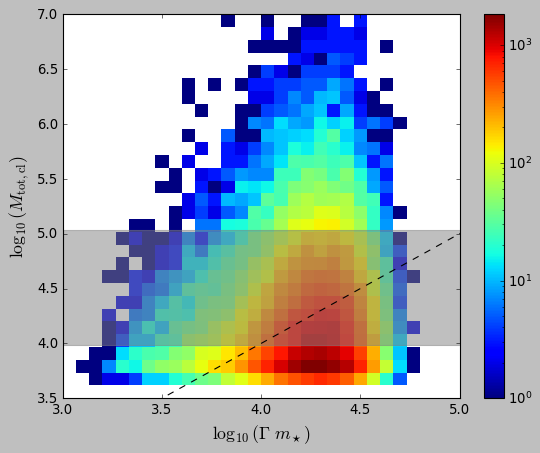

In [77]:
cb = plt.hist2d(np.log10(s.data['lcfe'][mask_cluster_initial]*s.data['gima'][mask_cluster_initial]*1e10),
           np.log10(s.data['imfc'][mask_cluster_initial]*s.data['gima'][mask_cluster_initial]*1e10), range=([3,5], [3.5,7]), bins=(30,30),rasterized=True, norm=mcolors.LogNorm())
plt.plot(np.linspace(3,7, 50), np.linspace(3,7, 50), 'k--')
plt.fill_betweenx([np.unique(np.log10(1e10*s.data['gima'][mask_cluster_initial]))[0],np.unique(np.log10(1e10*s.data['gima'][mask_cluster_initial]))[-1]],\
                   3, 5, where=[True,True], color='grey', alpha=0.5)
plt.xlim(3,5)
plt.ylim(3.5,7)
plt.xlabel(r'$\log_{10} ( \Gamma \; m_\star)$', fontsize=16)
plt.ylabel(r'$\log_{10} ( M_{\rm{tot,cl}})$', fontsize=16)
plt.colorbar(cb[3])

In [78]:
galrad

0.10731983184814453

In [79]:
ICMF_array=[]

for i in range(len(mtrunc)):
    ICMF_array.append(ICMF(norm[i], marray_gcmf, mtrunc[i]))

ICMF_array = np.array(ICMF_array)

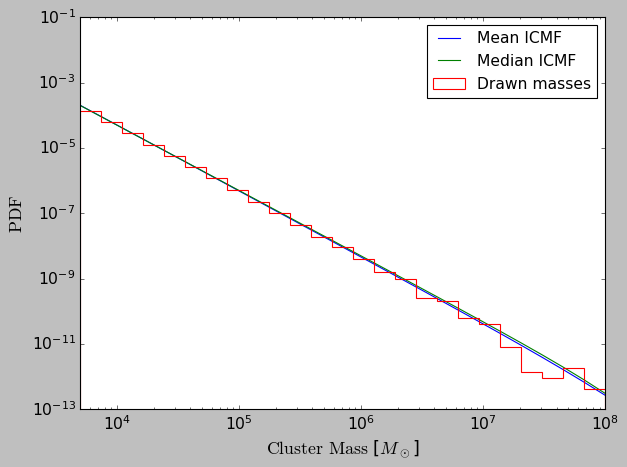

In [80]:
plt.loglog(marray_gcmf, np.nanmean(ICMF_array,axis=0), label='Mean ICMF')
plt.loglog(marray_gcmf, np.nanmedian(ICMF_array,axis=0), label='Median ICMF')
# plt.hist(imtotclus/inclus, bins=marray_gcmf, density=True, histtype='step', label='Drawn masses')
plt.hist(imclus[imclus>0], bins=marray_gcmf, density=True, histtype='step', label='Drawn masses')
# plt.step(marray_gcmf[:-1], initial_population, where='post', label='Initial Population')
plt.legend(fontsize=14)
# plt.ylim(1e-13, 1e-1)
plt.xlim(min_gcmf, max_gcmf)
plt.xlabel(r'$\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', fontsize=16)
plt.ylabel(r'$\rm{PDF}$', fontsize=16)
plt.yticks(np.logspace(-13, -1, 7))
plt.tick_params(axis='both', which='both', labelsize=14)
plt.tight_layout()
# plt.savefig('plots/icmf_sampling_test_consistent.pdf')

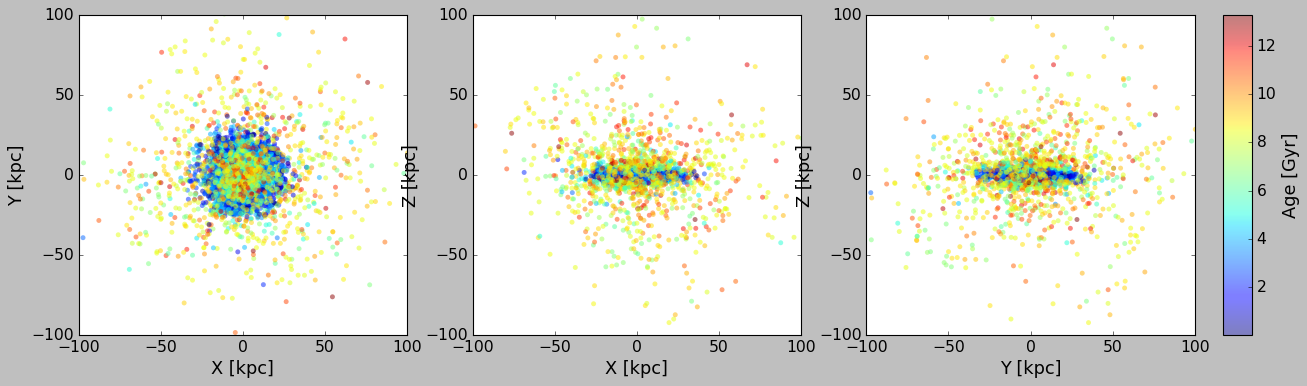

In [81]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))
ax[0].scatter(1e3*s.data['pos'][starparts][mask_cluster_final][:,1], 1e3*s.data['pos'][starparts][mask_cluster_final][:,2],
                 c=stars_age[mask_cluster_final], alpha=0.5, linewidth=0)
ax[0].set_xlim(-100,100)
ax[0].set_ylim(-100,100)
ax[0].set_xlabel('X [kpc]', fontsize=16)
ax[0].set_ylabel('Y [kpc]', fontsize=16)
ax[0].tick_params(axis='both', which='both', labelsize=14)
ax[1].scatter(1e3*s.data['pos'][starparts][mask_cluster_final][:,2], 1e3*s.data['pos'][starparts][mask_cluster_final][:,0],
                 c=stars_age[mask_cluster_final], alpha=0.5, linewidth=0)
ax[1].set_xlim(-100,100)
ax[1].set_ylim(-100,100)
ax[1].set_xlabel('X [kpc]', fontsize=16)
ax[1].set_ylabel('Z [kpc]', fontsize=16)
ax[1].tick_params(axis='both', which='both', labelsize=14)
cb = ax[2].scatter(1e3*s.data['pos'][starparts][mask_cluster_final][:,1], 1e3*s.data['pos'][starparts][mask_cluster_final][:,0],
                 c=stars_age[mask_cluster_final], alpha=0.5, linewidth=0)
ax[2].set_xlim(-100,100)
ax[2].set_ylim(-100,100)
ax[2].set_xlabel('Y [kpc]', fontsize=16)
ax[2].set_ylabel('Z [kpc]', fontsize=16)
ax[2].tick_params(axis='both', which='both', labelsize=14)
cbar = fig.colorbar(cb, cax=fig.add_axes([0.92, 0.1, 0.02, 0.8]))
cbar.set_label('Age [Gyr]', fontsize=16)
cbar.ax.tick_params(labelsize=14)
# plt.savefig('./plots/'+simulation_list[3]+'_position_age_distribution.pdf')

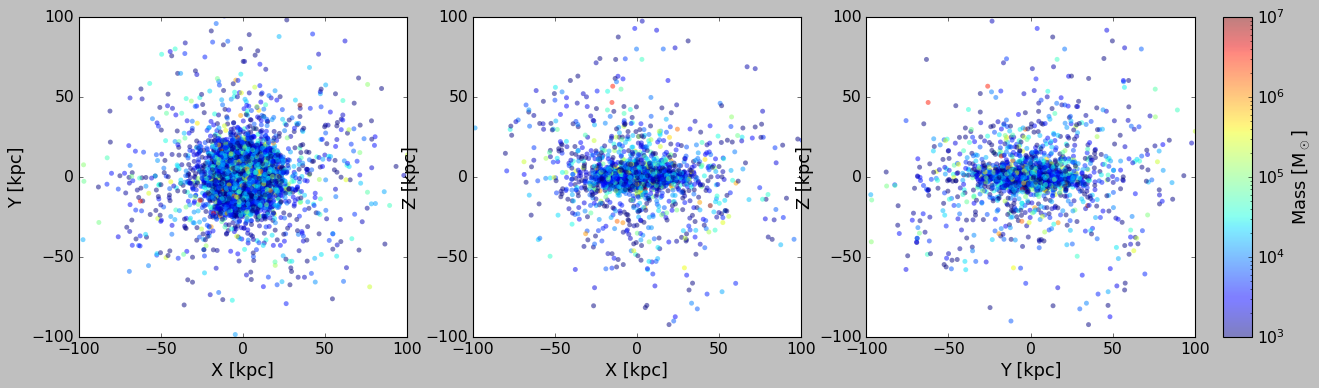

In [82]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))
ax[0].scatter(1e3*s.data['pos'][starparts][mask_cluster_final][:,1], 1e3*s.data['pos'][starparts][mask_cluster_final][:,2], 
              c=(1e10*s.data['mass'][starparts]*s.data['mfcl'])[mask_cluster_final], norm=mcolors.LogNorm(vmin=1e3, vmax=1e7), alpha=0.5, linewidth=0)
ax[0].set_xlim(-100,100)
ax[0].set_ylim(-100,100)
ax[0].set_xlabel('X [kpc]', fontsize=16)
ax[0].set_ylabel('Y [kpc]', fontsize=16)
ax[0].tick_params(axis='both', which='both', labelsize=14)
ax[1].scatter(1e3*s.data['pos'][starparts][mask_cluster_final][:,2], 1e3*s.data['pos'][starparts][mask_cluster_final][:,0], 
              c=(1e10*s.data['mass'][starparts]*s.data['mfcl'])[mask_cluster_final], norm=mcolors.LogNorm(vmin=1e3, vmax=1e7), alpha=0.5, linewidth=0)
ax[1].set_xlim(-100,100)
ax[1].set_ylim(-100,100)
ax[1].set_xlabel('X [kpc]', fontsize=16)
ax[1].set_ylabel('Z [kpc]', fontsize=16)
ax[1].tick_params(axis='both', which='both', labelsize=14)
cb = ax[2].scatter(1e3*s.data['pos'][starparts][mask_cluster_final][:,1], 1e3*s.data['pos'][starparts][mask_cluster_final][:,0], 
              c=(1e10*s.data['mass'][starparts]*s.data['mfcl'])[mask_cluster_final], norm=mcolors.LogNorm(vmin=1e3, vmax=1e7), alpha=0.5, linewidth=0)
ax[2].set_xlim(-100,100)
ax[2].set_ylim(-100,100)
ax[2].set_xlabel('Y [kpc]', fontsize=16)
ax[2].set_ylabel('Z [kpc]', fontsize=16)
ax[2].tick_params(axis='both', which='both', labelsize=14)
cbar = fig.colorbar(cb, cax=fig.add_axes([0.92, 0.1, 0.02, 0.8]))
cbar.set_label('Mass [M$_\odot$]', fontsize=16)
cbar.ax.tick_params(labelsize=14)
# plt.savefig('./plots/'+simulation_list[3]+'_position_mass_distribution.pdf')

In [83]:
mclus = s.data['mclt'][mask_cluster_final].flatten()
mclus = mclus[mclus>0]
nclus = s.data['nclt'][mask_cluster_final]

In [84]:
kinetic_energy = np.sum(s.data['vel']**2, axis=1)

orbital_energy = s.data['pot'] + 0.5 * kinetic_energy
orbital_energy /= 1e5
e_max = np.nanmax(orbital_energy)
orbital_energy -= e_max

J_mod = np.sqrt((np.cross(s.data['pos'], s.data['vel'])**2).sum(axis=1))
Lz = np.cross( s.data['pos'], (s.data['vel'] ) )[:,0]
Lz *= np.sign(np.nanmedian(Lz))

parts_radius = s.r()
isort_parts = np.argsort(parts_radius)
revert_sort = np.argsort(isort_parts)
cummass = np.cumsum(s.data['mass'][isort_parts])
Vc_parts = np.sqrt(Gcosmo*cummass[revert_sort]/parts_radius)

Ecirc = 0.5*Vc_parts[isort_parts]**2 + s.data['pot'][isort_parts]
Ecirc /= 1e5
# e_max = np.nanmax(Ecirc[~np.isinf(Ecirc)])
# orbital_energy -= e_max
Ecirc -= e_max

In [ ]:
istars, = np.where((s.data['age'] > 0) )
pos = s.data['pos']
vel = s.data['vel']
pot = s.data['pot']
j  = pylab.cross( pos[istars,:], vel[istars,:] )
jz = j[:,0]
spec_energy = 0.5 * (vel[istars,:]**2).sum(axis=1) + pot[istars]
eps2 = jz
ii = np.argsort(spec_energy)
npm = 50
# eps2 = eps2[ii]
eps2 /= [ np.max(eps2[:i+npm]) if i < npm else np.max(eps2[i-npm:]) if i > size(ii)-npm else np.max(eps2[i-npm:i+npm]) for i in range(size(ii)) ]

(array([2.53347781e-04, 5.13469567e-04, 9.55134682e-04, 2.03626585e-03,
        4.53722844e-03, 1.39463212e-02, 5.22519637e-02, 1.70963689e-01,
        3.34389265e-01, 1.19835126e+00, 1.72787522e+00, 5.86986486e-01,
        4.04265835e-01, 2.74729250e-01, 1.77982913e-01, 4.99623501e-02,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 array([-2. , -1.8, -1.6, -1.4, -1.2, -1. , -0.8, -0.6, -0.4, -0.2,  0. ,
         0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ]),
 [<matplotlib.patches.Polygon at 0x7f36a741f940>])

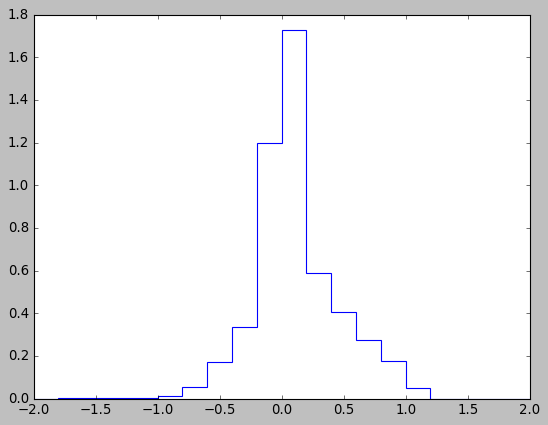

In [92]:
plt.hist(eps2, bins=20, histtype='step', range=[-2,2], density=True)

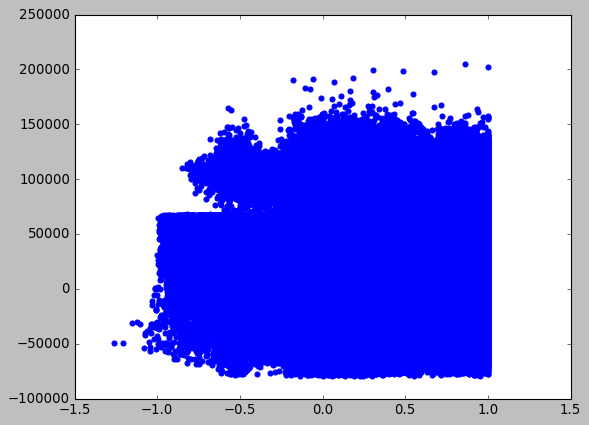

In [89]:
plt.scatter(eps2, spec_energy, edgecolors='face')

In [20]:
def mask_equal_to_previous(arr):
    mask = np.ones(len(arr), dtype=bool)
    mask[1:] = arr[1:] != arr[:-1]
    return mask

# Example usage
mask = mask_equal_to_previous(parts_radius[isort_parts][~np.isinf(Ecirc)])

In [21]:
r_test = np.logspace(-5, np.log10(parts_radius.max()), 500)
Ecirc_f = sp.interpolate.PchipInterpolator(parts_radius[isort_parts][~np.isinf(Ecirc)][mask], Ecirc[~np.isinf(Ecirc)][mask])
Vc_f = sp.interpolate.PchipInterpolator(parts_radius[isort_parts][~np.isinf(Ecirc)][mask], Vc_parts[isort_parts][~np.isinf(Ecirc)][mask])
Mr_f = sp.interpolate.PchipInterpolator(parts_radius[isort_parts][~np.isinf(Ecirc)][mask], cummass[~np.isinf(Ecirc)][mask])

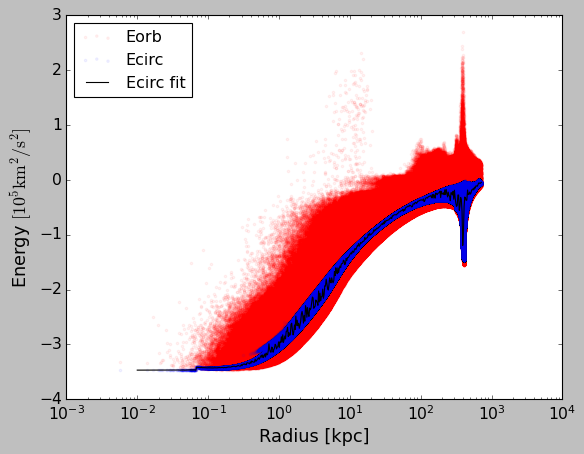

In [22]:
plt.scatter(1e3*parts_radius[isort_parts][~np.isinf(Ecirc)][mask], orbital_energy[isort_parts][~np.isinf(Ecirc)][mask], c='r', edgecolors='face', label='Eorb', s=5, alpha=0.05)
plt.scatter(1e3*parts_radius[isort_parts][~np.isinf(Ecirc)][mask], Ecirc[~np.isinf(Ecirc)][mask], edgecolors='face', label='Ecirc', s=5, alpha=0.05)
plt.plot(1e3*r_test, Ecirc_f(r_test), c='k', label='Ecirc fit')
plt.legend(loc='upper left')
plt.xscale('log')
plt.xlabel('Radius [kpc]', fontsize=16)
plt.ylabel(r'Energy $[10^5 \rm{km}^2/\rm{s}^2]$', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)

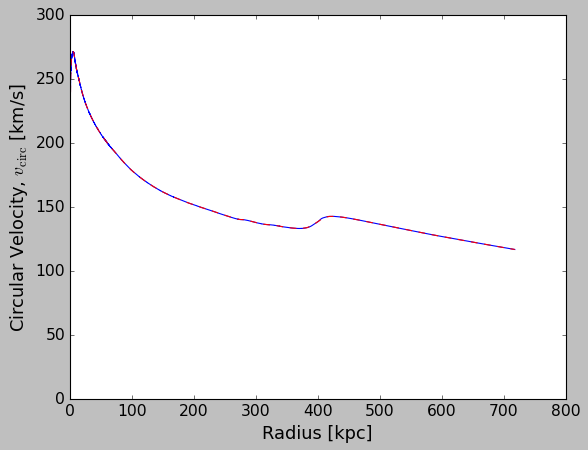

In [23]:
plt.plot(1e3*parts_radius[isort_parts], Vc_parts[isort_parts])
plt.plot(1e3*r_test, Vc_f(r_test), 'r--')
plt.xlabel('Radius [kpc]', fontsize=16)
plt.ylabel(r'Circular Velocity, $v_{\rm{circ}}$ [km/s]', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)
plt.tick_params(axis='both', which='both', labelsize=14)

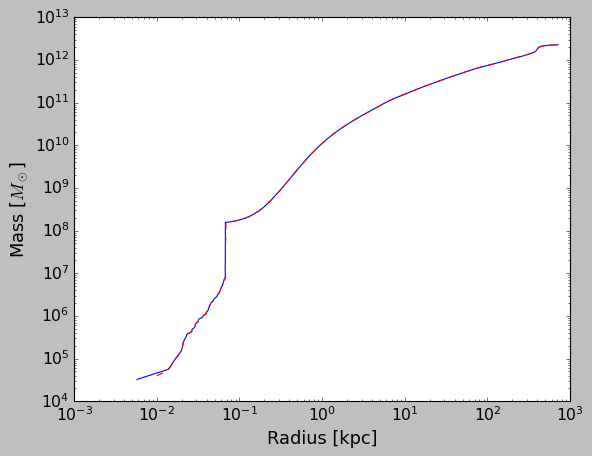

In [24]:
plt.plot(1e3*parts_radius[isort_parts], 1e10*cummass)
plt.plot(1e3*r_test, 1e10*Mr_f(r_test), 'r--')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Radius [kpc]', fontsize=16)
plt.ylabel(r'Mass [$M_\odot$]', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)

In [25]:
@njit(parallel=True)
def velocity_dispersion(radius, parts_radius, starparts, s_data_age, s_data_vel, s_data_type):
    # Select particles within the given radius
    within_radius = parts_radius[starparts][s_data_age > 0.] < radius
    if within_radius.sum() >= 48:
        velocities = np.sqrt(np.sum(s_data_vel[starparts][s_data_age > 0.][within_radius]**2, axis=1))
    # if not enough stars, use dark matter particles
    else:
        mask_dm = (s_data_type != 4) * (s_data_type != 0)
        within_radius = parts_radius[mask_dm] < radius
        velocities = np.sqrt(np.sum(s_data_vel[mask_dm][within_radius]**2, axis=1))

    # Calculate the velocity dispersion
    if velocities.size == 0:
        return 0.0
    # Avoid division by zero
    else:
        return np.std(velocities)

def B(x):
    return sp.special.erf(x) * 2.*x*np.exp(-x**2)/np.sqrt(np.pi)

In [26]:
idx = np.argmin(np.abs(orbital_energy[starparts][mask_cluster_final][:,np.newaxis] - Ecirc_f(r_test)), axis=1)
rc_clus = r_test[idx]
vc_rc_clus = Vc_f(rc_clus)
M_rc_clus = Mr_f(rc_clus)
# sigma_rc_clus = np.array([velocity_dispersion(rc, parts_radius, starparts, s.data['age'], s.data['vel'], s.data['type']) for rc in rc_clus])

rc_clus = np.repeat(rc_clus, nclus)
M_rc_clus = np.repeat(M_rc_clus, nclus)
vc_rc_clus = np.repeat(vc_rc_clus, nclus)
# sigma_rc_clus = np.repeat(sigma_rc_clus, nclus)

In [27]:
r_clus = np.repeat(parts_radius[starparts][mask_cluster_final],nclus)
vc_clus = np.repeat(Vc_parts[starparts][mask_cluster_final],nclus)

(0.0, 500.0)

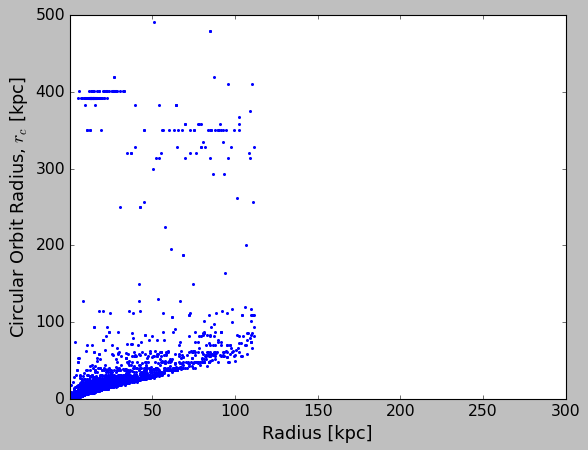

In [28]:
plt.scatter(1e3*r_clus,1e3*rc_clus, s=3, edgecolors='face')
plt.xlabel('Radius [kpc]', fontsize=16)
plt.ylabel('Circular Orbit Radius, $r_c$ [kpc]', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)
plt.xlim(0,300)
plt.ylim(0,500)

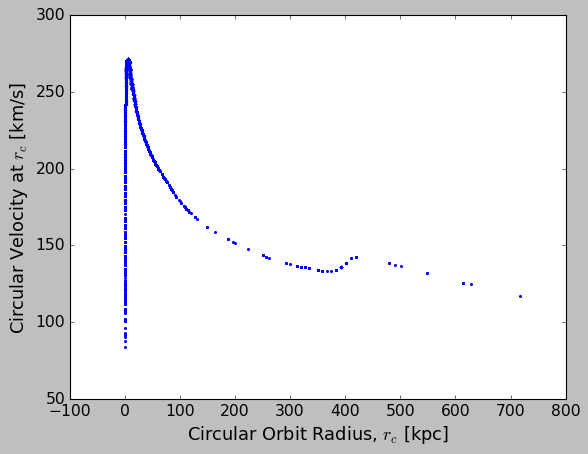

In [29]:
plt.scatter(1e3*rc_clus,vc_rc_clus, s=3, edgecolors='face')
plt.xlabel('Circular Orbit Radius, $r_c$ [kpc]', fontsize=16)
plt.ylabel('Circular Velocity at $r_c$ [km/s]', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)

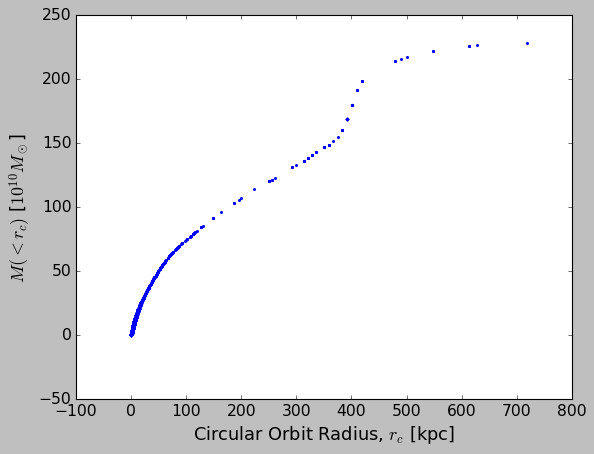

In [30]:
plt.scatter(1e3*rc_clus,M_rc_clus, s=3, edgecolors='face')
plt.xlabel('Circular Orbit Radius, $r_c$ [kpc]', fontsize=16)
plt.ylabel(r'$M(<r_c)$ [$10^{10} M_\odot$]', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)

In [31]:
# plt.scatter(1e3*rc_clus,sigma_rc_clus, s=3, edgecolors='face')
# plt.xlabel('Circular Orbit Radius, $r_c$ [kpc]', fontsize=16)
# plt.ylabel('Velocity Dispersion [km/s]', fontsize=16)
# plt.tick_params(axis='both', which='both', labelsize=14)

In [32]:
Jc_clus = rc_clus*vc_clus
circ_param_clus0 = np.repeat(Lz[starparts][mask_cluster_final],s.data['nclt'][mask_cluster_final])/Jc_clus
# circ_param_clus1 = (np.repeat(J_mod[starparts][mask_cluster_final],s.data['nclt'][mask_cluster_final])/Jc_clus)

In [33]:
circ_param_clus0.min(),circ_param_clus0.max()#, circ_param_clus1.min(), circ_param_clus1.max()

(-1.1316902394079689, 1.4127410121683368)

In [34]:
# feps = (circ_param_clus1)**0.78
# coulumblog = np.log(1. + M_rc_clus/mclus)

In [35]:
# tdf = feps/(2*B(vc_rc_clus/(np.sqrt(2.)*sigma_rc_clus)))*np.sqrt(2.)*sigma_rc_clus*rc_clus**2./(Gcosmo*mclus*coulumblog)
# tdf *= s.UnitLength_in_cm/s.UnitVelocity_in_cm_per_s / (1e9*365.25*24*3600)
# np.nanmin(tdf), np.nanmax(tdf)
clus_age = np.repeat(stars_age[mask_cluster_final],nclus)
clus_age_i = np.repeat(stars_age[mask_cluster_initial],s.data['incl'][mask_cluster_initial])
# mask_disrupted = (tdf<clus_age)
# mask_disrupted.sum()

In [36]:
# plt.hist(tdf, bins=np.logspace(-1, 3, 20), histtype='step')
# plt.xscale('log')
# plt.xlabel('Dynamical Friction Timescale [Gyr]', fontsize=16)
# plt.ylabel('Number of Clusters', fontsize=16)
# plt.tick_params(axis='both', which='both', labelsize=14)

In [37]:
# cb = plt.scatter(tdf, 1e10*mclus, s=3, c=clus_age, edgecolors='face')
# plt.xscale('log')
# plt.yscale('log')
# cbar = plt.colorbar(cb)
# cbar.set_label('Age [Gyr]', fontsize=16)
# cbar.ax.tick_params(labelsize=14)
# plt.xlabel('Dynamical Friction Timescale [Gyr]', fontsize=16)
# plt.ylabel('Cluster Mass [$M_\odot$]', fontsize=16)
# xticks = plt.xticks()[0]
# plt.xticks(xticks[::2])
# plt.tick_params(axis='both', which='both', labelsize=14)

In [38]:
nbins = 20
min_gcmf = 1e2 # in solar masses
max_gcmf = 1e8 # in solar masses
marray_gcmf = np.linspace(np.log10(min_gcmf), np.log10(max_gcmf), nbins + 1)
width = np.diff(marray_gcmf)

In [39]:
# plt.hist(np.log10(1e10*mclus[mask_disrupted]), bins=marray_gcmf, histtype='step', label='All Clusters', linewidth=3)
# plt.xlabel(r'$\log M_{\mathrm{cl}}$ $[M_\odot]$', fontsize=16)
# plt.ylabel(r'$\rm{Disrupted \; Clusters} (\tau < t_{\rm{DF}})$', fontsize=16)
# plt.tick_params(axis='both', which='both', labelsize=14)

In [40]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

idx = np.argmin(np.abs(orbital_energy[starparts][(s.data['age']>0)*(parts_radius[starparts]<galrad)][:,np.newaxis] - Ecirc_f(r_test)), axis=1)
rc_stars = r_test[idx]
Vc_rc_stars = Vc_f(rc_stars)
Lzmax = rc_stars * Vc_rc_stars
eps = Lz[starparts][(s.data['age']>0)*(parts_radius[starparts]<galrad)] / Lzmax

# mask_eps = np.abs(eps)>1.0
# eps[mask_eps] = 1.0 * np.sign(eps[mask_eps])

# Build feature array: [ε, Energy]
X = np.vstack((eps,
               orbital_energy[starparts][(s.data['age']>0)*(parts_radius[starparts]<galrad)])).T
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit GMM
gmm = GaussianMixture(n_components=2, means_init=[[0.0,np.median(orbital_energy[starparts][(s.data['age']>0)*(s.r()[starparts]<galrad)])],
                                                  [1.0,np.median(orbital_energy[starparts][(s.data['age']>0)*(s.r()[starparts]<galrad)])]],
                                                  covariance_type='full', random_state=42)
gmm.fit(X_scaled)

# Predict cluster memberships
decomp_labels = gmm.predict(X_scaled)

In [41]:
median_eps = [np.median(eps[decomp_labels==i]) for i in range(gmm.n_components)]
gc_label = np.argmin(median_eps)
print('GMM Cluster Label for GC:', gc_label)

GMM Cluster Label for GC: 0


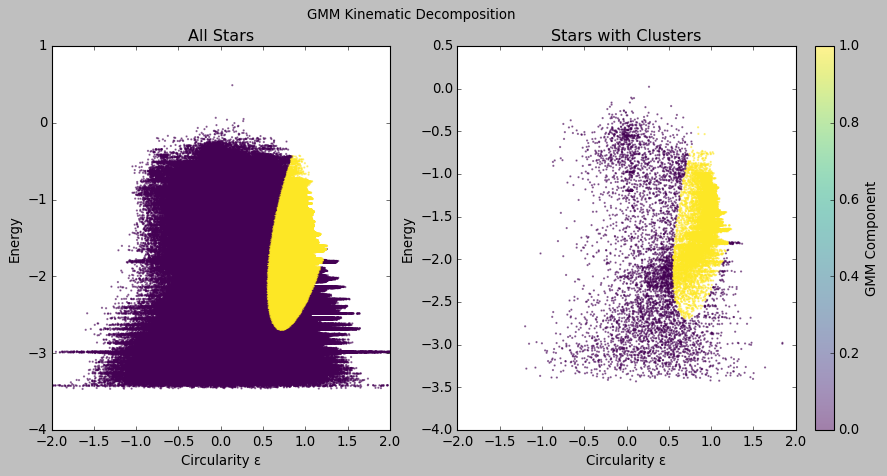

In [47]:
mask = (s.data['nclt'][(s.data['age']>0)*(parts_radius[starparts]<galrad)]>0)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(eps, orbital_energy[starparts][(s.data['age']>0)*(s.r()[starparts]<galrad)], c=decomp_labels, s=1, cmap='viridis', alpha=0.5, edgecolors='face')
cb = ax[1].scatter(eps[mask], orbital_energy[starparts][(s.data['age']>0)*(s.r()[starparts]<galrad)][mask], c=decomp_labels[mask], s=1, cmap='viridis', alpha=0.5, edgecolors='face')
for i in range(2):
    ax[i].set_xlabel('Circularity ε')
    ax[i].set_xlim(-2,2)
    ax[i].set_ylabel('Energy')
fig.suptitle('GMM Kinematic Decomposition')
ax[0].set_title('All Stars')
ax[1].set_title('Stars with Clusters')
fig.colorbar(cb, cax=fig.add_axes([0.92, 0.1, 0.02, 0.8]), label='GMM Component')

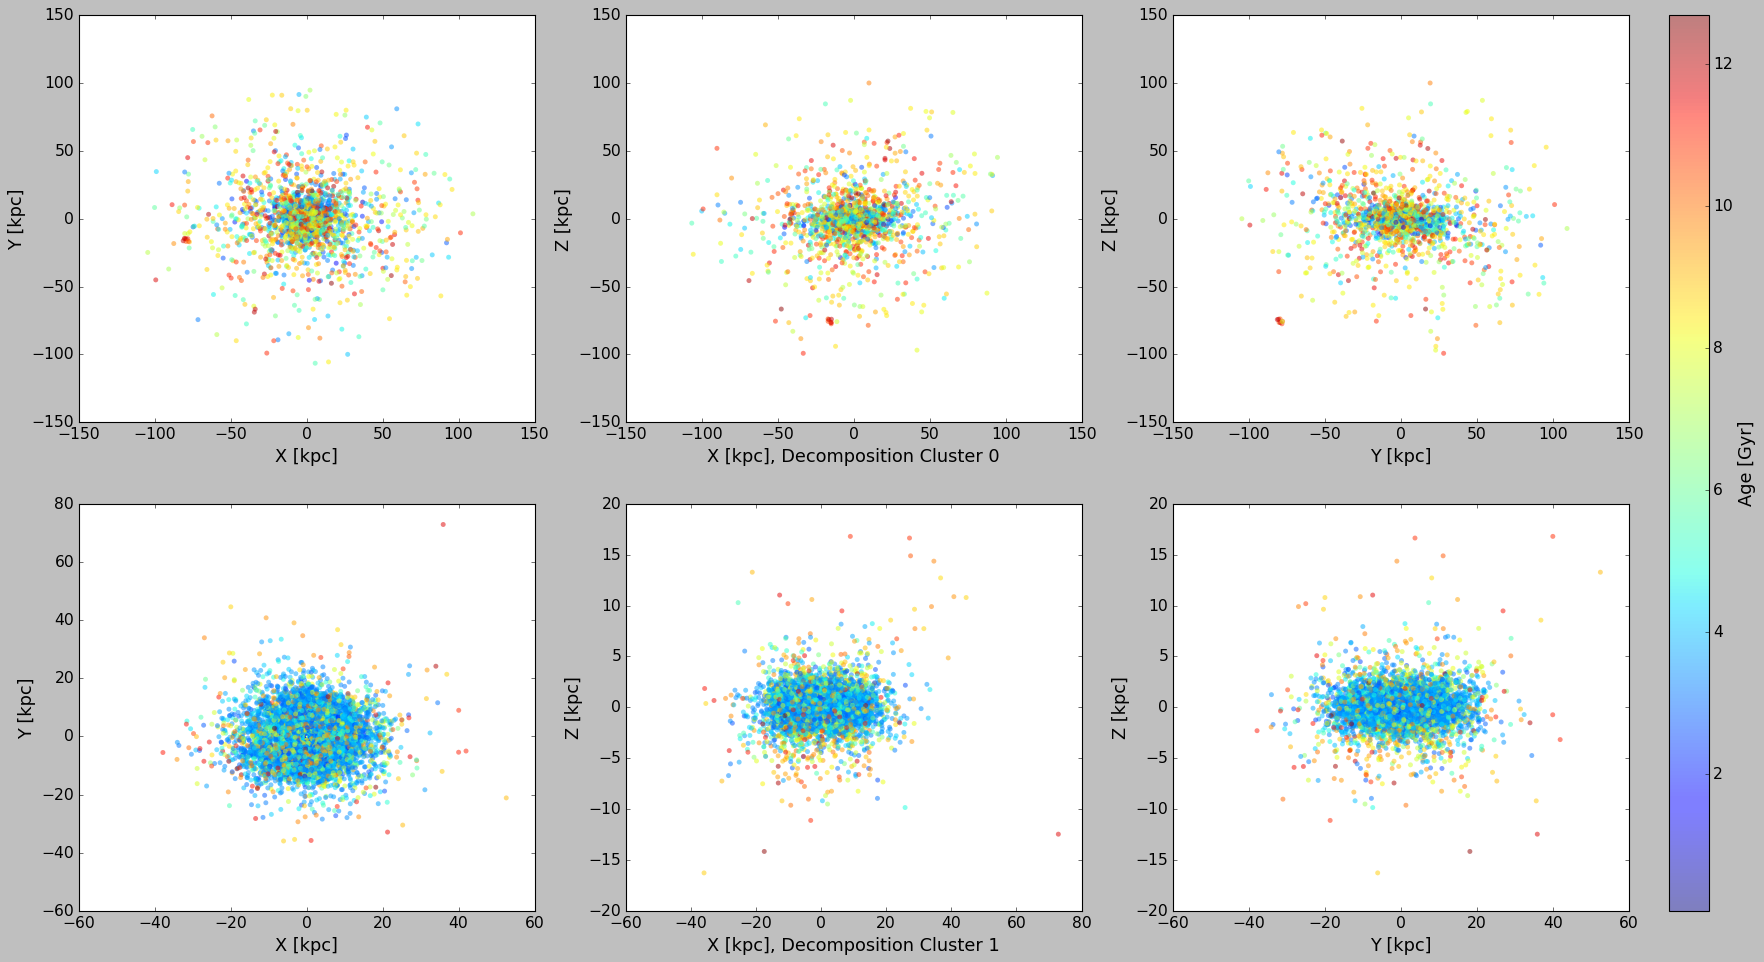

In [48]:
nlabels = gmm.n_components
fig, ax = plt.subplots(nlabels, 3, figsize=(25,7*nlabels))
for i in range(nlabels):
    ax[i,0].scatter(1e3*s.data['pos'][starparts][mask_cluster_final][decomp_labels[mask]==i][:,1], 1e3*s.data['pos'][starparts][mask_cluster_final][decomp_labels[mask]==i][:,2],
                    c=stars_age[mask_cluster_final][decomp_labels[mask]==i], alpha=0.5, linewidth=0)
    ax[i,0].set_xlabel('X [kpc]', fontsize=16)
    ax[i,0].set_ylabel('Y [kpc]', fontsize=16)
    ax[i,0].tick_params(axis='both', which='both', labelsize=14)
    ax[i,1].scatter(1e3*s.data['pos'][starparts][mask_cluster_final][decomp_labels[mask]==i][:,2], 1e3*s.data['pos'][starparts][mask_cluster_final][decomp_labels[mask]==i][:,0],
                    c=stars_age[mask_cluster_final][decomp_labels[mask]==i], alpha=0.5, linewidth=0)
    ax[i,1].set_xlabel('X [kpc], Decomposition Cluster {:1d}'.format(i), fontsize=16)
    ax[i,1].set_ylabel('Z [kpc]', fontsize=16)
    ax[i,1].tick_params(axis='both', which='both', labelsize=14)
    cb = ax[i, 2].scatter(1e3*s.data['pos'][starparts][mask_cluster_final][decomp_labels[mask]==i][:,1], 1e3*s.data['pos'][starparts][mask_cluster_final][decomp_labels[mask]==i][:,0],
                    c=stars_age[mask_cluster_final][decomp_labels[mask]==i], alpha=0.5, linewidth=0)
    ax[i, 2].set_xlabel('Y [kpc]', fontsize=16)
    ax[i, 2].set_ylabel('Z [kpc]', fontsize=16)
    ax[i, 2].tick_params(axis='both', which='both', labelsize=14)
cbar = fig.colorbar(cb, cax=fig.add_axes([0.92, 0.1, 0.02, 0.8]))
cbar.set_label('Age [Gyr]', fontsize=16)
cbar.ax.tick_params(labelsize=14)
# plt.savefig('./plots/'+simulation_list[3]+'_position_age_distribution.pdf')

([], [])

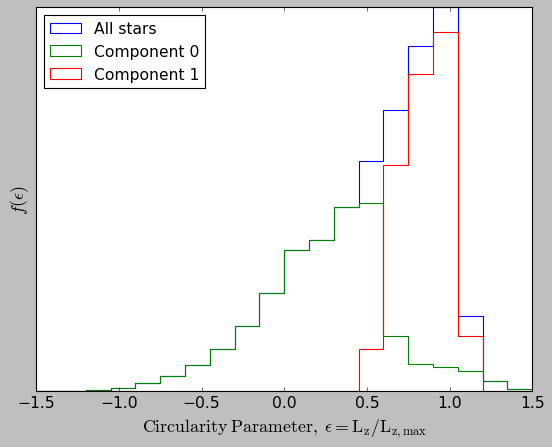

In [49]:
plt.hist(eps, histtype='step', bins=20, range=[-1.5,1.5], label='All stars')
for i in range(gmm.n_components):
    plt.hist(eps[decomp_labels==i], histtype='step', bins=20, range=[-1.5,1.5], label=f'Component {i}')
plt.legend(loc='upper left', fontsize=14)
# plt.vlines(0.8,0,1.4, color='r', linestyles='dashed')
plt.xlabel(r'$\rm{Circularity \; Parameter}, \; \epsilon = L_z/L_{z,\mathrm{max}}$', fontsize=16)
plt.ylabel(r'$f(\epsilon)$', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)
plt.yticks([])

In [93]:
m31_masses = np.genfromtxt('catalogues_compare/Caldwell_dataonly.txt', usecols=11, delimiter=',')
mw_catalogue = np.genfromtxt('catalogues_compare/Harris_onlyphotometry.txt', usecols=(0,6,12), delimiter=',', skip_header=1)
mw_masses = np.log10(1.7 * 10**(0.4*(4.83 - mw_catalogue[:,1])))
N,_ = np.histogram(m31_masses, bins=marray_gcmf)
m31_mass_function = N/width
N,_ = np.histogram(mw_masses, bins=marray_gcmf)
mw_mass_function = N/width

labels = np.repeat(decomp_labels, s.data['nclt'][(s.data['age']>0)*(s.r()[starparts]<galrad)])

# fig, ax = plt.subplots(1,2, figsize=(14,5), sharey=True, gridspec_kw={'hspace': 0.1, 'wspace': 0.})

# N,_ = np.histogram(np.log10(1e10*mclus[(~mask_disrupted)]), bins=marray_gcmf)
# all_clusters = N/width
# # N,_ = np.histogram(np.log10(1e10*mclus[(~mask_disrupted)]), bins=marray_gcmf)
# # after_df = N/width
# N,_ = np.histogram(np.log10(1e10*mclus[(~mask_disrupted) * (clus_age>6.)]), bins=marray_gcmf)
# after_df_intermediate = N/width
# N,_ = np.histogram(np.log10(1e10*mclus[(~mask_disrupted) *(clus_age>8.)]), bins=marray_gcmf)
# after_df_old = N/width

# ax[0].step(marray_gcmf[:-1], all_clusters, where='post',c='k', linewidth = 3, label='All Clusters')
# # ax[0].step(marray_gcmf[:-1], after_df, where='post',c='b', linewidth = 3, label=r'$\epsilon < 0.8$')
# ax[0].step(marray_gcmf[:-1], after_df_intermediate, where='post',c='r', linewidth = 3, label=r'$\epsilon < 0.8, \tau > 6 \; \rm{Gyr}$')
# ax[0].step(marray_gcmf[:-1], after_df_old, where='post',c='g', linewidth = 3, label=r'$\epsilon < 0.8, \tau > 10 \; \rm{Gyr}$')

# N,_ = np.histogram(np.log10(1e10*mclus[(~mask_disrupted) * (decomp_labels==0)]), bins=marray_gcmf)
# after_df = N/width
# N,_ = np.histogram(np.log10(1e10*mclus[(~mask_disrupted) * (clus_age>6.) * (decomp_labels==0)]), bins=marray_gcmf)
# after_df_intermediate = N/width
# N,_ = np.histogram(np.log10(1e10*mclus[(~mask_disrupted) *(clus_age>8.) * (decomp_labels==0)]), bins=marray_gcmf)
# after_df_old = N/width

# ax[1].step(marray_gcmf[:-1], after_df, where='post',c='b', linewidth = 3, label='Spheroid')
# ax[1].step(marray_gcmf[:-1], after_df_intermediate, where='post',c='r', linewidth = 3, label=r'$\tau > 6 \; \rm{Gyr}$')
# ax[1].step(marray_gcmf[:-1], after_df_old, where='post',c='g', linewidth = 3, label=r'$\tau > 8 \; \rm{Gyr}$')

# for ax_i in ax:
#     ax_i.step(marray_gcmf[:-1], mw_mass_function, where='post',linewidth=3, c='c', label='MW')
#     ax_i.step(marray_gcmf[:-1], m31_mass_function, where='post',linewidth=3, c='m', label='M31')
#     ax_i.set_xlabel(r'$\log M_{\mathrm{cl}}$ $[M_\odot]$', fontsize=16)
#     ax_i.set_xlim(2, 7.5)
#     ax_i.tick_params(axis='both', which='both', labelsize=14)
# ax[0].set_yscale('log')
# ax[0].set_ylim(5e0, 1e4)
# ax[0].set_ylabel(r'$\mathrm{d}N \, / \, \mathrm{d} \log M_{\mathrm{cl}}$', fontsize=16)
# ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)

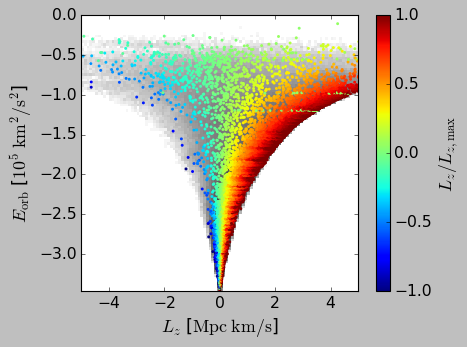

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5), tight_layout=True)
#index, = np.where((s.r() < 0.1) & (s.r() > 0.0))
ax.hist2d( Lz[starparts][(s.data['age']>0)*(s.r()[starparts]<galrad)], orbital_energy[starparts][(s.data['age']>0)*(s.r()[starparts]<galrad)], bins=(100, 100), range=([-5, 5], [orbital_energy[starparts][(s.data['age']>0)*(s.r()[starparts]<galrad)].min(), 0.]), rasterized=True, cmap='Greys', norm=mcolors.LogNorm() )
cb = ax.scatter(Lz[starparts][mask_cluster_final], orbital_energy[starparts][mask_cluster_final], c=eps[mask], vmin=-1, vmax=1, s=7, edgecolors='face', linewidth=0)
ax.set_ylim(orbital_energy[starparts][(s.data['age']>0)*(s.r()[starparts]<galrad)].min(), 0)
cbar = fig.colorbar(cb, ax=ax)
cbar.set_label(r'$L_z / L_{z,\rm{max}}$', fontsize=16)
cbar.ax.tick_params(labelsize=14)
plt.xlabel(r'$L_z$ [$\rm{Mpc} \; \rm{km}/\rm{s}$]', fontsize=16)
plt.ylabel(r'$E_{\rm{orb}}$ [$10^5 \; \rm{km}^2/\rm{s}^2$]', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)

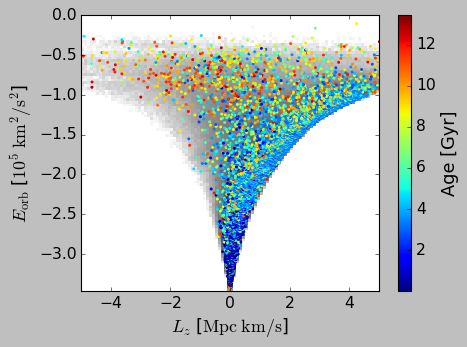

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5), tight_layout=True)
ax.hist2d( Lz[starparts][(s.data['age']>0)*(s.r()[starparts]<galrad)], orbital_energy[starparts][(s.data['age']>0)*(s.r()[starparts]<galrad)], bins=(100, 100), range=([-5, 5], [orbital_energy[starparts][(s.data['age']>0)*(s.r()[starparts]<galrad)].min(), 0.]), rasterized=True, cmap='Greys', norm=mcolors.LogNorm() )
cb = ax.scatter( Lz[starparts][mask_cluster_final], orbital_energy[starparts][mask_cluster_final], c=stars_age[mask_cluster_final], s=7, edgecolors='face', linewidth=0)
ax.set_ylim(orbital_energy[starparts][(s.data['age']>0)*(s.r()[starparts]<galrad)].min(), 0)
cbar = fig.colorbar(cb, ax=ax)
cbar.set_label('Age [Gyr]', fontsize=16)
cbar.ax.tick_params(labelsize=14)
plt.xlabel(r'$L_z$ [$\rm{Mpc} \; \rm{km}/\rm{s}$]', fontsize=16)
plt.ylabel(r'$E_{\rm{orb}}$ [$10^5 \; \rm{km}^2/\rm{s}^2$]', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)

In [56]:
# plt.hist(clus_age[~mask_disrupted], bins=20, histtype='step', density=True, label='All Clusters')
# plt.hist(clus_age[(~mask_disrupted) * (labels == 0)], bins=20, histtype='step', density=True, label=r'GCs candidates (Spheroidal)')
# plt.ylim(0, 0.35)
# plt.legend(loc='upper left', fontsize=14)
# plt.xlabel('Cluster`s age [Gyr]', fontsize=16)
# plt.ylabel('Age Distribution', fontsize=16)
# plt.tick_params(axis='both', which='both', labelsize=14)

/tmp/ipykernel_3354502/560626995.py:1: RuntimeWarning: divide by zero encountered in log10
  logPoverk = np.repeat(np.log10(s.data['bprs'][(s.data['age']>0)*(s.r()[starparts]<galrad)]/k), s.data['nclt'][(s.data['age']>0)*(s.r()[starparts]<galrad)])
/tmp/ipykernel_3354502/560626995.py:2: RuntimeWarning: divide by zero encountered in log10
  logPoverk_i = np.repeat(np.log10(s.data['bprs'][(s.data['age']>0)*(s.r()[starparts]<galrad)]/k), s.data['incl'][(s.data['age']>0)*(s.r()[starparts]<galrad)])


Text(0, 0.5, '$\\log P/k$ [$\\rm{K}/\\rm{cm}^3$]')

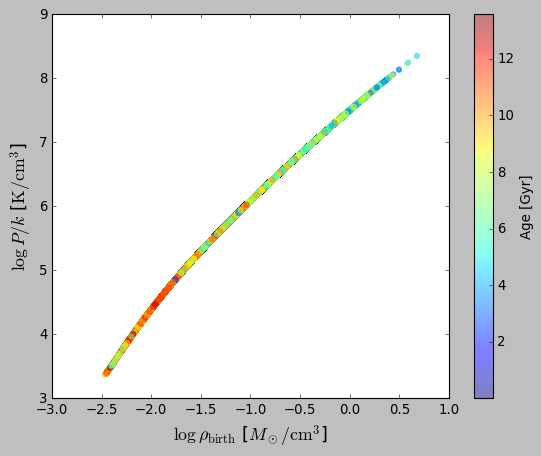

In [57]:
logPoverk = np.repeat(np.log10(s.data['bprs'][(s.data['age']>0)*(s.r()[starparts]<galrad)]/k), s.data['nclt'][(s.data['age']>0)*(s.r()[starparts]<galrad)])
logPoverk_i = np.repeat(np.log10(s.data['bprs'][(s.data['age']>0)*(s.r()[starparts]<galrad)]/k), s.data['incl'][(s.data['age']>0)*(s.r()[starparts]<galrad)])
logdens = np.repeat(np.log10(s.data['bdens'][(s.data['age']>0)*(s.r()[starparts]<galrad)] * parsec**3/solar_mass_g), s.data['nclt'][(s.data['age']>0)*(s.r()[starparts]<galrad)])
logdens_i = np.repeat(np.log10(s.data['bdens'][(s.data['age']>0)*(s.r()[starparts]<galrad)] * parsec**3/solar_mass_g), s.data['incl'][(s.data['age']>0)*(s.r()[starparts]<galrad)])

plt.scatter(logdens_i, logPoverk_i, c=clus_age_i, alpha=0.5, edgecolors='face')
plt.colorbar(label='Age [Gyr]')
plt.xlabel(r'$\log \rho_{\rm{birth}}$ [$M_\odot/\rm{cm}^3$]', fontsize=16)
plt.ylabel(r'$\log P/k$ [$\rm{K}/\rm{cm}^3$]', fontsize=16)

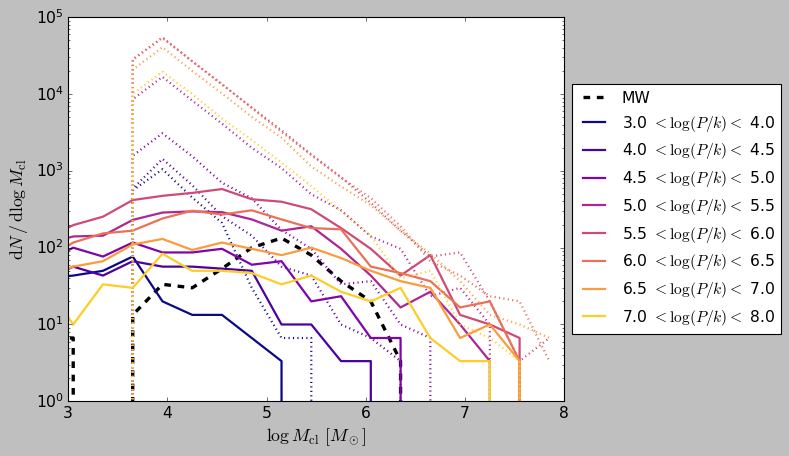

In [58]:
bins_logPoverk = np.concatenate([[3.0],np.arange(4,7.5,0.5),[8.0]])
colors = plt.cm.plasma(np.linspace(0, 0.9, 8))
plt.plot((marray_gcmf[:-1] + marray_gcmf[1:])/2., mw_mass_function, 'k--', linewidth=3, label='MW')
# plt.plot((marray_gcmf[:-1] + marray_gcmf[1:])/2., m31_mass_function, 'k-.', linewidth=3, label='M31')
for i in range(8):
    mask = (logPoverk > bins_logPoverk[i]) & (logPoverk < bins_logPoverk[i+1])
    mask_i = (logPoverk_i > bins_logPoverk[i]) & (logPoverk_i < bins_logPoverk[i+1])
    N,_ = np.histogram(np.log10(1e10*mclus[(clus_age>6.) * mask]), bins=marray_gcmf)
    after_df_intermediate = N/width
    plt.plot((marray_gcmf[:-1] + marray_gcmf[1:])/2., after_df_intermediate, c=colors[i], linewidth = 2, label=f'{bins_logPoverk[i]:.1f} $< \log(P/k) <$ {bins_logPoverk[i+1]:.1f}')
    N,_ = np.histogram(np.log10(imclus[imclus>0][(clus_age_i>6.) * mask_i]), bins=marray_gcmf)
    initial_per_pressbin = N/width
    plt.plot((marray_gcmf[:-1] + marray_gcmf[1:])/2., initial_per_pressbin, c=colors[i], linestyle = 'dotted', linewidth = 2)

plt.yscale('log')
# plt.ylim(5e0, 5e3)
plt.xlim(3, 8)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
plt.xlabel(r'$\log M_{\mathrm{cl}}$ $[M_\odot]$', fontsize=16)
plt.ylabel(r'$\mathrm{d}N \, / \, \mathrm{d} \log M_{\mathrm{cl}}$', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)
# plt.savefig('plots/gcmf_per_birthpressure.pdf',bbox_inches='tight')

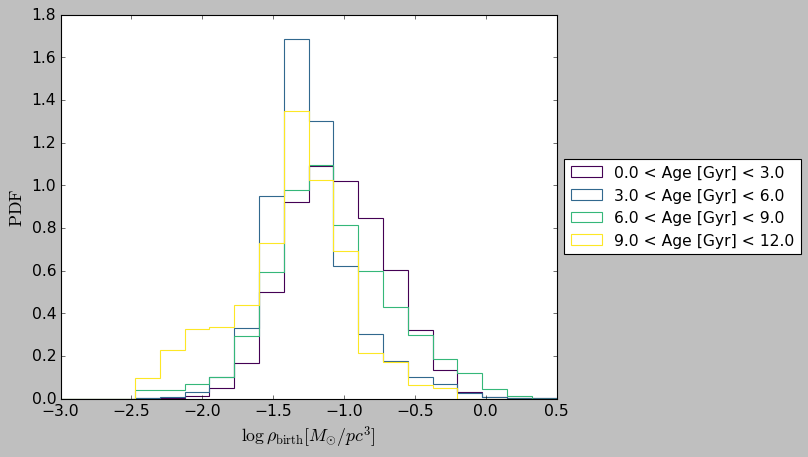

In [59]:
bins_ages = np.arange(0, 15, 3)
colors = plt.cm.viridis(np.linspace(0, 1, 4))
for i in range(len(bins_ages)-1):
    mask = (clus_age > bins_ages[i]) & (clus_age < bins_ages[i+1])
    plt.hist(logdens[mask], bins=20, range=[-3, 0.5], histtype='step', density=True, color=colors[i], label=f'{bins_ages[i]:.1f} < Age [Gyr] < {bins_ages[i+1]:.1f}')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
plt.xlabel(r'$\log \rho_{\rm{birth}} [M_{\odot}/pc^3]$', fontsize=16)
plt.ylabel(r'$\rm{PDF}$', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)

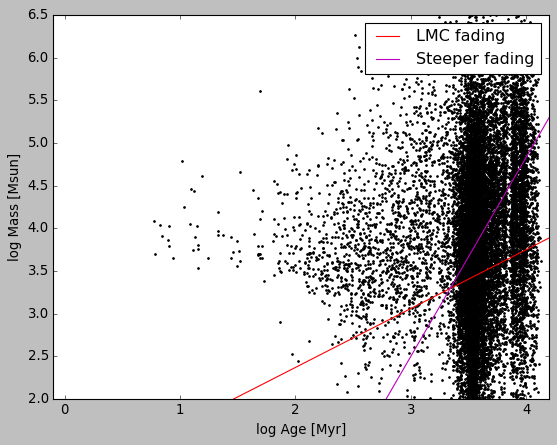

In [60]:
plt.scatter(np.log10(1e3*clus_age), np.log10(1e10*mclus), c='k', s=2)
logage = np.linspace(1, 4.2, 100)
fading1 = 0.69*logage + 0.99
fading2 = 7/3. * logage - 4.5
plt.plot(logage, fading1, c='r', label='LMC fading')
plt.plot(logage, fading2, c='m', label='Steeper fading')
plt.xlim(-.1, 4.2)
plt.ylim(2, 6.5)
plt.xlabel('log Age [Myr]')
plt.ylabel('log Mass [Msun]')
plt.legend()

In [61]:
def density_scatter( x , y, vmin, vmax, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density=False)
    z = sp.interpolate.interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    h = ax.scatter( x, y, c=z, norm=mcolors.LogNorm(vmin=vmin, vmax=vmax),cmap=cm.viridis, **kwargs )

    return ax, h

In [62]:
min_icmf = 5e3 # in solar masses
max_icmf = 1e8 # in solar masses
marray_icmf = np.linspace(np.log10(min_icmf), np.log10(max_icmf), nbins + 1)

mclus_i = s.data['imcl'][(s.data['age']>0)*(s.r()[starparts]<galrad)].flatten()
mclus_m = s.data['mclt'][(s.data['age']>0)*(s.r()[starparts]<galrad)].flatten()
mlsh = s.data['mlsk'][(s.data['age']>0)*(s.r()[starparts]<galrad)].flatten()
mlrx = s.data['mlrx'][(s.data['age']>0)*(s.r()[starparts]<galrad)].flatten()
drpt_t = s.data['drpt'][(s.data['age']>0)*(s.r()[starparts]<galrad)].flatten()
drpt_t = drpt_t[mclus_i>0]
mclus_m = mclus_m[mclus_i>0]*1e10
mlsh = mlsh[mclus_i>0]*1e10
mlrx = mlrx[mclus_i>0]*1e10
mclus_i = mclus_i[mclus_i>0]*1e10

fraction = []
for i in range(nbins):
  mask = (np.log10(mclus_i) > marray_icmf[i]) & (np.log10(mclus_i) < marray_icmf[i+1])
  mask_disrupted = (drpt_t[mask]>0)
  fraction.append(mask_disrupted.sum()/mask.sum())

fraction = np.array(fraction)
fraction = np.nan_to_num(fraction, nan=0.)
drpt_t = s.cosmology_get_lookback_time_from_a(drpt_t, is_flat=True)

massfraction = []
for i in range(nbins):
  mask = (np.log10(mclus_i) > marray_icmf[i]) & (np.log10(mclus_i) < marray_icmf[i+1])
  massfraction.append(mclus_m[mask].sum()/mclus_i[mask].sum())

massfraction = np.array(massfraction)
massfraction = np.nan_to_num(massfraction, nan=0.)

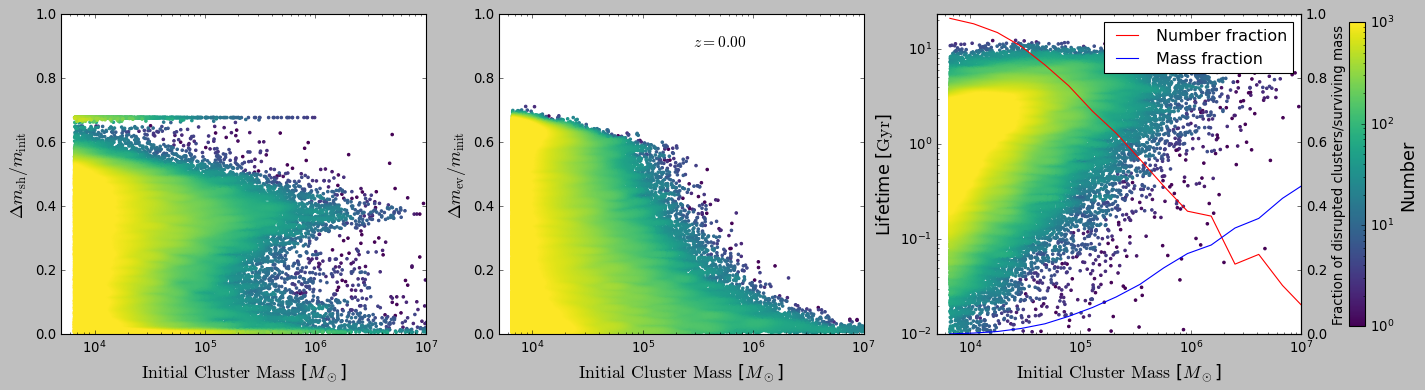

In [63]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
ax[0], cb1 = density_scatter(mclus_i, mlsh/mclus_i, vmin=1e0, vmax=1e3, ax=ax[0],bins=[10**marray_icmf, np.linspace(0,1.1,100)], edgecolors='face', s=5)
ax[0].set(xscale='log', xlim=(5e3, 1e7), ylim=(0,1))
ax[0].set_xlabel(r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', fontsize=16)
ax[0].set_ylabel(r'$\Delta m_{\rm{sh}}/m_{\rm{init}}$', fontsize=16)
ax[0].tick_params(labelsize=12)

ax[1], cb1 = density_scatter(mclus_i, mlrx/mclus_i, vmin=1e0, vmax=1e3, ax=ax[1],bins=[10**marray_icmf, np.linspace(0,1.1,100)], edgecolors='face', s=5)
ax[1].text(5e5, 0.9, r'$z={:.2f}$'.format(s.redshift), fontsize=14, ha='center')
ax[1].set(xscale='log', xlim=(5e3, 1e7), ylim=(0,1))
ax[1].set_xlabel(r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', fontsize=16)
ax[1].set_ylabel(r'$\Delta m_{\rm{ev}}/m_{\rm{init}}$', fontsize=16)
ax[1].tick_params(labelsize=12)

ax[2], cb = density_scatter(mclus_i, np.repeat(stars_age[(s.data['age']>0)*(s.r()[starparts]<galrad)],s.data['incl'][(s.data['age']>0)*(s.r()[starparts]<galrad)]) - drpt_t, vmin=1e0, vmax=1e3, ax=ax[2], bins=[10**marray_icmf, np.logspace(-2,1.5,100)], edgecolors='face', s=5)
ax[2].set(xscale='log', yscale='log', xlim=(5e3, 1e7), ylim=(1e-2, 2.3e1))
ax[2].set_xlabel(r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', fontsize=16)
ax[2].set_ylabel(r'Lifetime [$\rm{Gyr}$]', fontsize=16)
ax[2].tick_params(labelsize=12)
ax2 = ax[2].twinx()
ax2.plot((10**marray_icmf[:-1] + 10**marray_icmf[1:])/2, fraction, color='r', label='Number fraction')
ax2.plot((10**marray_icmf[:-1] + 10**marray_icmf[1:])/2, massfraction, color='b', label='Mass fraction')
ax2.set_ylim(0, 1)
ax2.set_ylabel('Fraction of disrupted clusters/surviving mass')
ax2.legend()
cbar_ax = fig.add_axes([.93, 0.12, 0.01, 0.76])
cbar = fig.colorbar(cb, cax=cbar_ax)
cbar.set_label('Number', size=16)

In [70]:
TT_gas = s.data['ttij'][s.data['type']==0][s.data['sfr']>0] / s.parameters['UnitTime_in_s']**2 * gyr**2
finite_mask_g = np.isfinite(TT_gas).all(axis=1)
TT_gas = TT_gas[finite_mask_g]
TT_star = s.data['ttij'][starparts][(stars_age<0.5)] / s.parameters['UnitTime_in_s']**2 * gyr**2
finite_mask_s = np.isfinite(TT_star).all(axis=1)
TT_star = TT_star[finite_mask_s]

TT_gas_lambda = np.linalg.eigvalsh(TT_gas.reshape(len(TT_gas),3,3))
TT_gas_lambda = np.sort(TT_gas_lambda, axis=1)
TT_star_lambda = np.linalg.eigvalsh(TT_star.reshape(len(TT_star),3,3))
TT_star_lambda = np.sort(TT_star_lambda, axis=1)

In [65]:
s.data['rho'] *= s.parameters['UnitMass_in_g']/ (s.parameters['UnitLength_in_cm']**3) / 1.6726e-24  # Convert to cm^-3

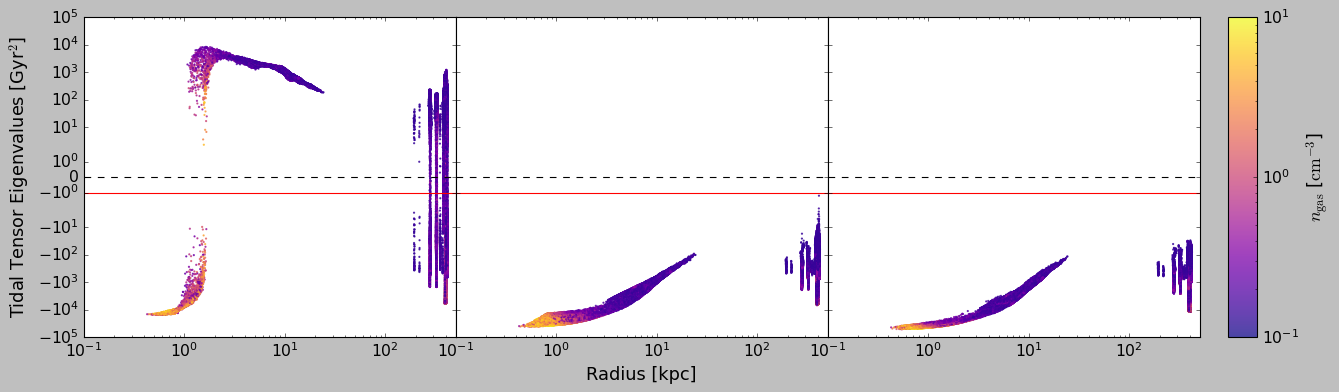

In [66]:
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(18,5))

for idx, axes in enumerate(ax):
    cb = axes.scatter(s.r()[s.data['type']==0][s.data['sfr']>0][finite_mask_g]*1e3, TT_gas_lambda[:,-1-idx], c=s.data['rho'][s.data['sfr']>0][finite_mask_g], edgecolors='face',\
                      s=1, alpha=0.75, norm=mcolors.LogNorm(vmin=1e-1, vmax=1e1), cmap='plasma')
    axes.hlines(0, 1e-1, 5e2, color='k', linestyles='dashed')
    axes.hlines(-1e0, 1e-1, 5e2, color='r')
    axes.set(yscale='symlog', ylim=(-1e5, 1e5), xscale='log', xlim=(1e-1, 5e2))
    # axes.set(yscale='symlog', xscale='log')
    axes.tick_params(axis='both', which='both', labelsize=14)

ax[0].set_ylabel(r'Tidal Tensor Eigenvalues [Gyr$^2$]', fontsize=16)
ax[1].set_xlabel('Radius [kpc]', fontsize=16)
cbar = fig.colorbar(cb, cax=fig.add_axes([0.92, 0.1, 0.02, 0.8]))
cbar.set_label(r'$n_{\rm{gas}}$ [$\rm{cm}^{-3}$]', fontsize=16)
cbar.ax.tick_params(labelsize=14)

plt.subplots_adjust(wspace=0.0)

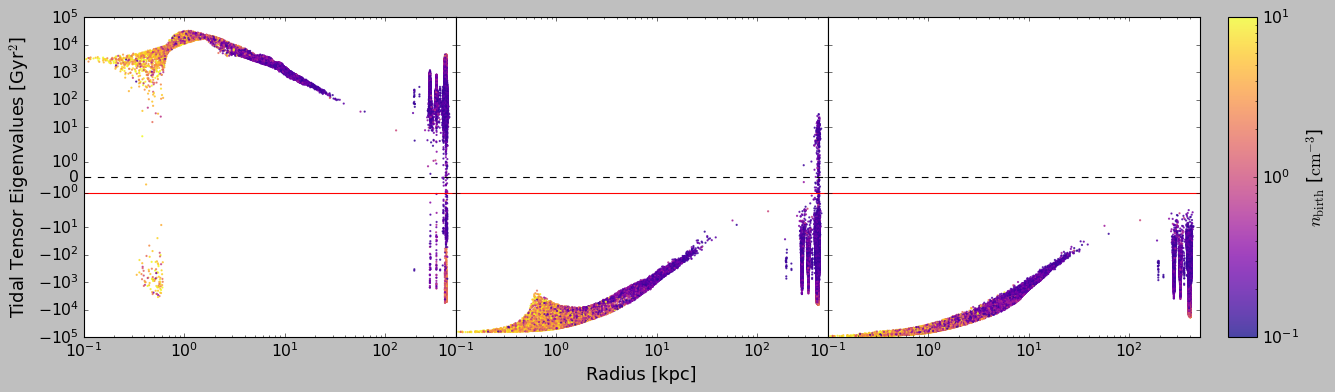

In [71]:
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(18,5))

for idx, axes in enumerate(ax):
    axes.scatter(s.r()[starparts][stars_age<0.5][finite_mask_s]*1e3, TT_star_lambda[:,-1-idx], c=s.data['bdens'][stars_age<0.5][finite_mask_s]/1.6726e-24,\
                  edgecolors='face', s=1, alpha=0.75, norm=mcolors.LogNorm(vmin=1e-1, vmax=1e1), cmap='plasma')
    axes.hlines(0, 1e-1, 5e2, color='k', linestyles='dashed')
    axes.hlines(-1e0, 1e-1, 5e2, color='r')
    axes.set(yscale='symlog', ylim=(-1e5, 1e5), xscale='log', xlim=(1e-1, 5e2))
    axes.tick_params(axis='both', which='both', labelsize=14)

ax[0].set_ylabel(r'Tidal Tensor Eigenvalues [Gyr$^2$]', fontsize=16)
ax[1].set_xlabel('Radius [kpc]', fontsize=16)
cbar = fig.colorbar(cb, cax=fig.add_axes([0.92, 0.1, 0.02, 0.8]))
cbar.set_label(r'$n_{\rm{birth}}$ [$\rm{cm}^{-3}$]', fontsize=16)
cbar.ax.tick_params(labelsize=14)

plt.subplots_adjust(wspace=0.0)

Text(0, 0.5, '$\\Gamma$')

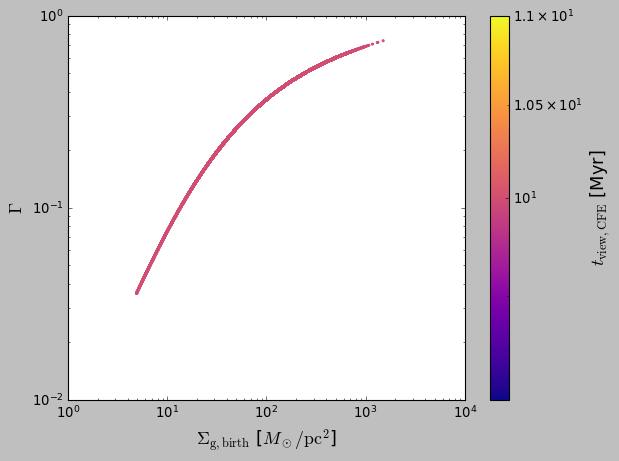

In [72]:
plt.scatter(s.data['bsig'][mask_cluster_initial] * parsec**2/solar_mass_g, s.data['lcfe'][mask_cluster_initial], \
            c=s.data['tcfe'][mask_cluster_initial]/3.15576e13, edgecolors='face', norm=mcolors.LogNorm(), cmap='plasma', s=3)
cb = plt.colorbar()
cb.set_label(label=r'$t_{\rm{view, CFE}}$ [Myr]', fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\Sigma_{\rm{g, birth}}$ [$M_\odot/\rm{pc}^2$]', fontsize=16)
plt.ylabel(r'$\Gamma$', fontsize=16)

Disrupted GCs: 968  of  3766


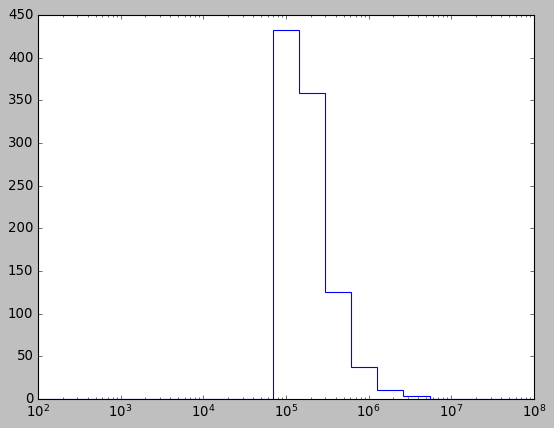

In [73]:
labels_i = np.repeat(decomp_labels, s.data['incl'][(s.data['age']>0)*(s.r()[starparts]<galrad)])
print('Disrupted GCs:', np.sum((mclus_i>1e5) * (labels_i!=gc_label) * (mclus_m < 1e2)), ' of ', np.sum((mclus_i>1e5) * (labels_i!=gc_label)))

plt.hist(mclus_i[(mclus_i>1e5) * (labels_i!=gc_label) * (mclus_m < 1e2)], bins=np.logspace(2, 8, 20), histtype='step', label='GCs')
plt.xscale('log')

In [64]:
treepath = path+simulation_list[sim_id]+'/trees/'
t = load_tree(0, 0, base=treepath+'trees_sf1_%03d' % snap_id, verbose=False)
"""Some of the quantities are automatically transformed at this step"""

TypeError: %d format: a real number is required, not builtin_function_or_method

In [ ]:
snap_numbers_main,redshifts_main,subfind_indices_main,first_progs_indices_main,ff_tree_indices_main,fof_indices_main,prog_mass_main,next_prog_indices = t.return_first_next_mass_progenitors(0)
print('snap_numbers_main,redshifts_main=',snap_numbers_main,redshifts_main)
print('subfind_indices_main,fof_indices_main=',subfind_indices_main,fof_indices_main)

snap_numbers_main,redshifts_main= [127 126 125 124 123 122 121 120 119 118 117 116 115 114 113 112 111 110
 109 108 107 106 105 104 103 102 101 100  99  98  97  96  95  94  93  92
  91  90  89  88  87  86  85  84  83  82  81  80  79  78  77  76  75  74
  73  72  71  70  69  68  67  66  65  64  63  62  61  60  59  58  57  56
  55  54  53  52  51  50  49  48  47  46  45  44  43  42  41  40  39  38
  37  36  35  34  33  32  31  30  29  28  27  26  25  24  23  22  21  20
  19  18] [2.22044605e-16 9.52166691e-03 2.39744280e-02 3.37243713e-02
 4.85236309e-02 5.85073233e-02 7.36613870e-02 8.38844329e-02
 9.94018018e-02 1.09869942e-01 1.25759333e-01 1.41876206e-01
 1.52748764e-01 1.69252038e-01 1.80385262e-01 1.97284177e-01
 2.14425042e-01 2.25988388e-01 2.43540183e-01 2.61343271e-01
 2.73353338e-01 2.91583240e-01 3.10074121e-01 3.28829736e-01
 3.47853839e-01 3.60687643e-01 3.80167872e-01 3.99926960e-01
 4.19968933e-01 4.40297842e-01 4.60917801e-01 4.81832951e-01
 5.03047526e-01 5.24565816e-01

(10000000000.0, 1000000000000.0)

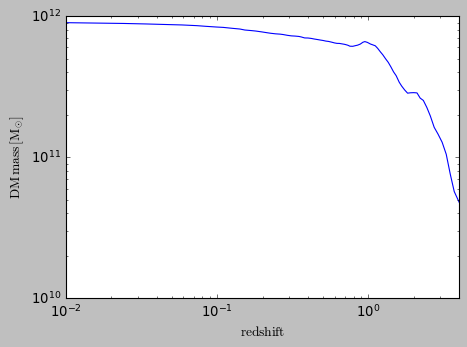

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(6, 4.5), tight_layout=True)
ax1.plot(t.data['reds'][first_progs_indices_main], t.data['smty'][first_progs_indices_main,1]*1e10)
ax1.set_xlabel('$\\rm redshift $')
ax1.set_ylabel('$\\rm{DM \, mass \, [M_{\odot}]}$')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlim(0.01,4.)
ax1.set_ylim(1e10, 1e12)

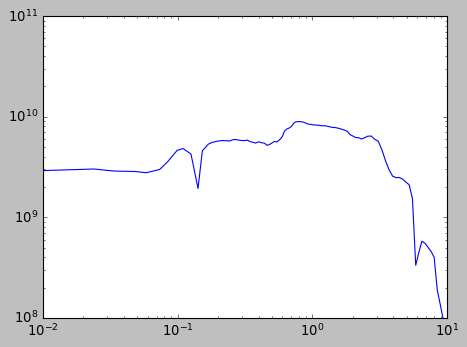

In [ ]:
snap_numbers,redshifts,subfind_indices,tree_indices,ff_tree_indices,fof_indices = t.return_subhalo_first_progenitors(2,127)

fig, ax1 = plt.subplots(1, 1, figsize=(6, 4.5), tight_layout=True)
ax1.plot(t.data['reds'][tree_indices], t.data['smty'][tree_indices][:,1]*1e10)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlim(0.01,10.)
ax1.set_ylim(1e8, 1e11)
fig.show()

In [ ]:
"""Read the accreted particle files with a gadget_readsnap() method"""

list_directory = path+simulation_list[sim_id]+'/lists/accretedstardata/%s/'%simulation_list[sim_id]
s.read_starparticle_mergertree_data_hdf5(snap_id, list_directory,'')
print(s.mdata)

1445179 in-situ and 244101 ex-situ stars found
{'Insitu': {'Npart': 1445179, 'ParticleIDs': array([8796088225786, 8796088276868, 7475548397499, ..., 8796160776719,
       8796160368598, 8796162679933], dtype=uint64)}, 'Exsitu': {'Npart': 244101, 'AccretedFlag': array([1, 0, 0, ..., 1, 1, 1], dtype=int32), 'BirthFoFindex': array([ -1,   3, 112, ...,   0,   0,   0], dtype=int32), 'BirthSubhaloindex': array([  0,   8, 140, ...,   1,   1,   1], dtype=int32), 'ParticleIDs': array([8796088188840, 8796088189904, 6817559459572, ..., 8796162988410,
       8796162991459, 8796163046202], dtype=uint64), 'PeakMassIndex': array([   -1, 26118,  9102, ...,   219,   219,   219], dtype=int32), 'RootIndex': array([    -1, 149115,  79152, ...,    219,    219,    219], dtype=int32), 'BoundFirstTime': array([-1.       , 10.690971 ,  7.1187997, ..., -1.       , -1.       ,
       -1.       ], dtype=float32), 'PeakMassInfalltime': array([13.829998 , 11.136676 ,  8.834415 , ...,  2.1695607,  2.1695607,
       

In [ ]:
first_prog = np.array(sorted(set(list(s.mdata['Exsitu']['PeakMassIndex']))))
print('first_prog=',first_prog,len(first_prog))
"""Count the number of star particles that are now bound to the main halo from each progenitor system, and sort in descending order of mass"""
nstars_in_subhalo = np.zeros(len(first_prog))
for i, pid in enumerate(first_prog):
    nstars_in_subhalo[i] = np.sum( (s.mdata['Exsitu']['PeakMassIndex']==pid) & (s.mdata['Exsitu']['AccretedFlag']==0))

print('finished finding stars for each progenitor.')
nsort = np.argsort(nstars_in_subhalo)[::-1]
nstars_in_subhalo = nstars_in_subhalo[nsort].astype('int')
first_prog = first_prog[nsort]
print('first_prog=',first_prog,len(first_prog))
print('nstars_in_subhalo=',nstars_in_subhalo)

first_prog= [    -1    126    130    140    147    175    219    229    442    582
   1046   1147   1226   3543   8954   9090   9102   9114   9322  10177
  10190  10337  11835  22936  24195  26118  26202  26233  26302  26414
  26559  26582  26695  26946  27080  27089  27357  27391  30005  30195
  30327  30370  30380  30623  30743  31222  31267  31357  31404  31416
  31531  31562  31655  31730  31782  31959  31998  32019  32025  32091
  32195  32424  32869  37760  37856  40776  40960  41353  42188  42239
  42320  42427  42516  44947  57418  60685  84741  95788 111245 124341
 129399 155763 161352 174717 233992] 85
finished finding stars for each progenitor.
first_prog= [ 26118  10177    175   9102   9322   9090  26302     -1  10337    219
   9114  27089   1147    229  10190  26233    140  26202  30327  27357
    147   8954  30743  30623  37760  26695  26946  24195  60685  42188
  26582  26559  27080  57418  31562  26414  31782    130  11835  31222
    126 111245 233992  31416  31357  314

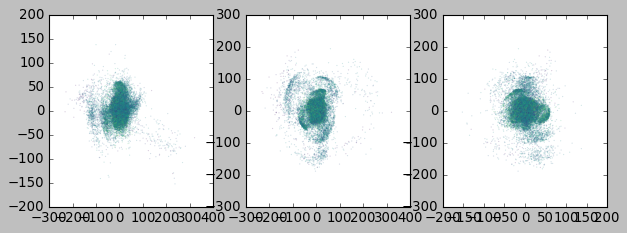

In [ ]:
"""Select 3rd most massive progenitor that merged with the MW"""
index = 2
index_firstprog, = np.where( ( s.mdata['Exsitu']['PeakMassIndex'] == first_prog[index] ) & (s.mdata['Exsitu']['AccretedFlag'] == 0) )
id_index_prog, = np.where( np.in1d( s.data['id'], s.mdata['Exsitu']['ParticleIDs'][index_firstprog] ) )
prog_star_positions = s.data['pos'][id_index_prog]

snapfb_thisprog = s.mdata['Exsitu']['BoundFirstTime'][index_firstprog]
c_index, = np.where( np.in1d(s.mdata['Exsitu']['ParticleIDs'][index_firstprog], s.data['id']) )
isort2 = np.argsort(s.mdata['Exsitu']['ParticleIDs'][ index_firstprog ][c_index])
pcolors = ( snapfb_thisprog[c_index[isort2]] - snapfb_thisprog.min() ) / ( snapfb_thisprog.max() - snapfb_thisprog.min() )

fig, ax = plt.subplots(1, 3, figsize=(9, 3))
ax[0].scatter( prog_star_positions[:,1]*1e3, prog_star_positions[:,2]*1e3, c=pcolors, s=5., marker='.', linewidth=0, cmap=plt.get_cmap('viridis'), alpha=0.2 )
ax[1].scatter( prog_star_positions[:,1]*1e3, prog_star_positions[:,0]*1e3, c=pcolors, s=5., marker='.', linewidth=0, cmap=plt.get_cmap('viridis'), alpha=0.2 )
ax[2].scatter( prog_star_positions[:,2]*1e3, prog_star_positions[:,0]*1e3, c=pcolors, s=5., marker='.', linewidth=0, cmap=plt.get_cmap('viridis'), alpha=0.2 )
fig.show()

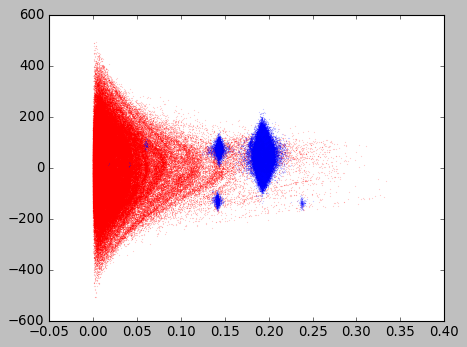

In [ ]:
index_accreted, = np.where((s.mdata['Exsitu']['AccretedFlag']==0))
id_index, = np.where( np.in1d( s.data['id'], s.mdata['Exsitu']['ParticleIDs'][index_accreted] ) )
prog_star_positions = s.data['pos'][id_index]
prog_star_velocities = s.data['vel'][id_index]
radii = np.sqrt( np.sum(prog_star_positions**2, axis=1) )
radial_velocities = np.sum(prog_star_positions * prog_star_velocities, axis=1) / radii

fig, ax = plt.subplots(1, 1, figsize=(6, 4.5), tight_layout=True)
ax.scatter( radii, radial_velocities, c='r', s=5, marker='.', linewidth=0, alpha=0.2 )

index_insat, = np.where((s.mdata['Exsitu']['AccretedFlag']==1))
id_index, = np.where( np.in1d( s.data['id'], s.mdata['Exsitu']['ParticleIDs'][index_insat] ) )
prog_star_positions = s.data['pos'][id_index]
prog_star_velocities = s.data['vel'][id_index]
radii = np.sqrt( np.sum(prog_star_positions**2, axis=1) )
radial_velocities = np.sum(prog_star_positions * prog_star_velocities, axis=1) / radii
ax.scatter( radii, radial_velocities, c='b', s=5, marker='.', linewidth=0, alpha=0.2 )

Doing progenitor 0 of 85
There are 167 unique root ids
Doing progenitor 1 of 85
There are 165 unique root ids
Doing progenitor 2 of 85
There are 110 unique root ids
Doing progenitor 3 of 85
There are 93 unique root ids
Doing progenitor 4 of 85
There are 124 unique root ids


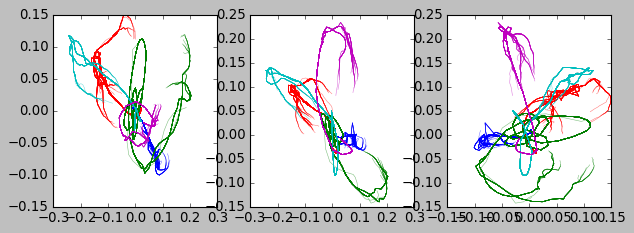

In [ ]:
fig2, ax2 = plt.subplots(1, 3, figsize=(9, 3))
colors = ['b', 'r', 'g', 'c', 'm', 'purple']
linecolorindex = 0
for i in range(5):
    index_firstprog0, = np.where( ( s.mdata['Exsitu']['PeakMassIndex'] == first_prog[i] ) & (s.mdata['Exsitu']['AccretedFlag'] == 0) )
    rootids = s.mdata['Exsitu']['RootIndex'][ index_firstprog0 ]
    print('Doing progenitor %d of %d'%(i,len(first_prog)))
    print('There are %d unique root ids'%len(np.unique(rootids)))
    for j,rootid in enumerate(np.unique(rootids)):
        desc = rootid
        xpos = []
        ypos = []
        zpos = []
        desc_list = []
        while t.data['desc'][desc] != -1:
            if t.data['desc'][desc] == first_progs_indices_main[ snap_numbers_main==t.data['snum'][t.data['desc'][desc]] ]:# and desc != -1:
                #print('Breaking loop for desc=',desc)
                break
            desc = t.data['desc'][desc]
            desc_list.append(desc)
            main_index, = np.where( snap_numbers_main == t.data['snum'][desc] )
            try:
                    xpos.append(t.data['spos'][desc][2] - t.data['spos'][first_progs_indices_main[main_index]][0][2])
                    ypos.append(t.data['spos'][desc][1] - t.data['spos'][first_progs_indices_main[main_index]][0][1])
                    zpos.append(t.data['spos'][desc][0] - t.data['spos'][first_progs_indices_main[main_index]][0][0])
            except:
                    pass
        ax2[0].plot( ypos, xpos, color=colors[linecolorindex%len(colors)], alpha=0.5, lw=0.5 )
        ax2[1].plot( ypos, zpos, color=colors[linecolorindex%len(colors)], alpha=0.5, lw=0.5 )
        ax2[2].plot( xpos, zpos, color=colors[linecolorindex%len(colors)], alpha=0.5, lw=0.5 )
    linecolorindex += 1